# Bollinger Bands Strategy and Backtesting Report

******************************************************
**Prepared By : Samalie Piwan**  
**Andrew ID: spiwan**  
**Semester: Fall 2023**  
**Last modified: 2nd October 2023**  
******************************************************

## Strategy Implementation

In [11]:
# Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO

In [50]:
#Set the fiat currency pair
from_symbol = "GBP"
to_symbol = "CAD"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

In [51]:
# Load the data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

In [52]:
#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

In [53]:
# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

In [67]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
# window : The SMA window
# length : The short period
# std : The long period

sma_window = 15
std = 2

In [68]:
def bb_backtest_strategy(symbol, data, date_col, pricing_col, param_window, param_std):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        param_window:
            The number of days to use when computing the Simple Moving Average
        param_length:
            The short period, also used when calculating the SMA
        param_std:
            The long period
            
    Return
    -----------
        None
    
    """

    main_df_indexed = data
    
    #Generate the bollinger bands
    #length (int): The short period. Default: 5
    #std (int): The long period. Default: 2
    #Function returns lower, mid, upper, bandwidth, and percent columns
    
    main_df_indexed.ta.bbands(close = pricing_col, length = sma_window, std= param_std, append = True)

    #Create f strings for the column names
    str_upper_band = f"BBU_{sma_window}_{std}.0"
    str_middle_band = f"BBM_{sma_window}_{std}.0"
    str_lower_band = f"BBL_{sma_window}_{std}.0"

    # Generate the trading signals
    # 1 Represents a buy
    # -1 represents a sell
    # 0 represents a hold
    bands_signal = []
    signal = 0

    for i in range(len(pricing_df['close'])):
        # Today's price is below the lower band
        # The price has dropped below the bands and a rise is expected
        # We want to buy
        #print("Close : "+str(pricing_df['close'][i]))
        #print("Lower : "+str(pricing_df[str_lower_band][i]))
        #print("Upper : "+str(pricing_df[str_upper_band][i]))

        if pricing_df['close'][i] < pricing_df[str_lower_band][i]:
            # If we are not already in a buy position
            # Add today's price to the buy list
            # Update the signal to show we are in buy
            signal = 1
            bands_signal.append(signal)

        # Today's price is above the upper band
        # The price has increased above the bands and a drop is expected
        # We want to sell
        elif pricing_df['close'][i] > pricing_df[str_upper_band][i]:

            # If we are not already in a sell position
            # Add today's price to the sell list
            # Update the signal to show we are in sell
            signal = -1
            bands_signal.append(signal)
        else:
            signal = 0
            bands_signal.append(signal)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(pricing_df['close'])):
        # If we are in a buy position, set our position as buy
        if bands_signal[i] == 1:
            position[i] = 1
        # If we are in a sell position, set our position as sell
        elif bands_signal[i] == -1:
            position[i] = 0
        # Otherwise use yesterday's position
        else:
            position[i] = position[i-1]
            
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Closing Price 60 min series | SMA "+str(param_window))
    main_df_indexed[pricing_col].plot(label = 'Prices', color = 'skyblue')
    main_df_indexed[str_upper_band].plot(label = 'Upper Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    main_df_indexed[str_middle_band].plot(label = 'Middle Band '+str(param_window), linestyle = '--', linewidth = 1.2, color = 'grey')
    main_df_indexed[str_lower_band].plot(label = 'Lower Band '+str(param_window), linestyle = '--', linewidth = 1, color = 'black')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper right')
    plt.show()

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Signal'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Position'] = position
    
    # Calculate Returns and Cummulative Returns and append to the DataFrame
    
    #New column name is LOGRET_1
    main_df_new.ta.log_return(close=pricing_col, append=True)
    
    #New column name is CUMLOGRET_1
    main_df_new.ta.log_return(close=pricing_col,cumulative=True, append=True)
    
    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Position'].shift(1) * main_df_new['LOGRET_1']
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum()
    
    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(from_symbol+"/"+to_symbol+" Equity Lines 60 min series | SMA "+str(param_window))
    plt.plot(main_df_new['CUMLOGRET_1'], label = "Returns")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    sns.set_style("whitegrid")
    plt.legend(loc='upper left')
    plt.show()

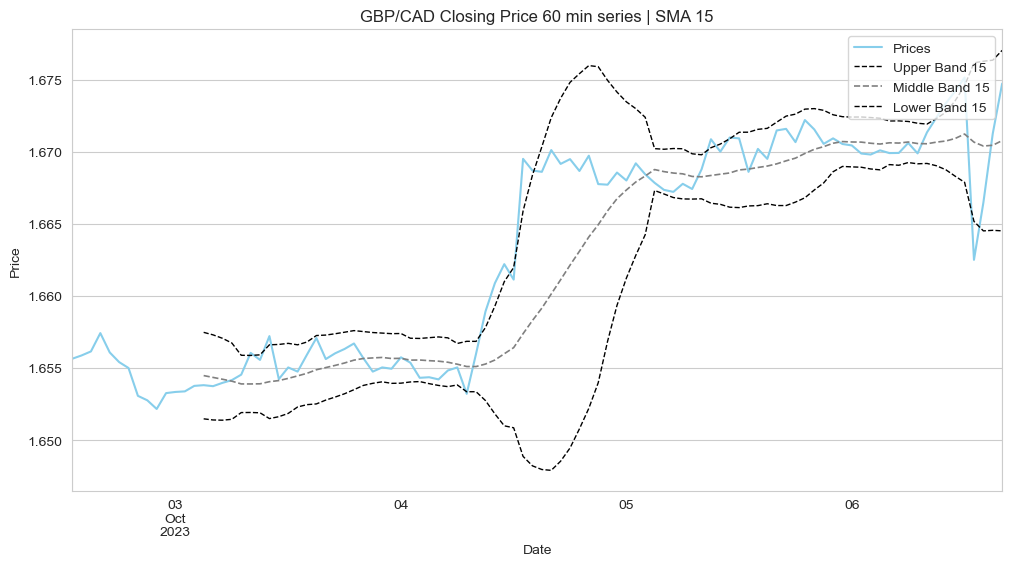

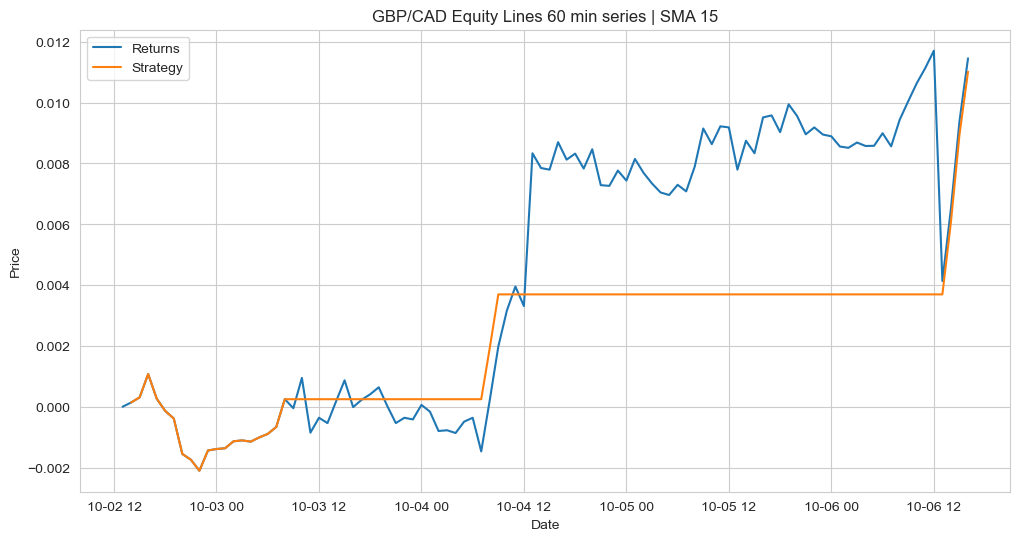

In [69]:
bb_backtest_strategy(f"{from_symbol}/{to_symbol}", pricing_df, 'timestamp', 'close', param_window = sma_window, param_std = std)

### Parameter Sensitivity Analysis

For this strategy, we will focus on the hyperparameters below:
    
- Simple Moving Average (SMA) Window
- Short Period
- Long Period

In [26]:
#Import the backtesting library
from backtesting import Backtest, Strategy
import backtesting

C:\Users\Sama\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [27]:
backtesting.set_bokeh_output(notebook=False)

In [28]:
def indicator(data, short_length, sma_window):
    #sma_window (int): The long period
    #short_length (int): The short period
    
    bbands = ta.bbands(close = data.Close.s, length = short_length, std = sma_window)
    return bbands.to_numpy().T[:3]

In [29]:
def optim_func(series):
    return series["Equity Final [$]"] / series["Exposure Time [%]"]

In [30]:
class BollingerBandsStrategy(Strategy):
    
    short_length = 90
    sma_window = 10
    
    def init(self):
        self.bbands = self.I(indicator, self.data, self.short_length, self.sma_window)
        pass

    def next(self):
        lower_band = self.bbands[0]
        upper_band = self.bbands[2]
        
        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] > lower_band[-1]:
                self.buy()

In [31]:
# Create an instance of the Backtest class and run the backtest

bt = Backtest(pricing_df, BollingerBandsStrategy, cash=5000, commission=0.001)
stats = bt.run()
print(stats)
bt.plot()

ValueError: `data` must be a pandas.DataFrame with columns 'Open', 'High', 'Low', 'Close', and (optionally) 'Volume'

In [24]:
stats, heatmap = bt.optimize(
    sma_window = range(1, 20, 1),
    short_length = range(1, 10, 1),
    maximize = optim_func,
    return_heatmap = True
)

hm = heatmap.groupby(["sma_window", "short_length"]).mean().unstack()

NameError: name 'bt' is not defined

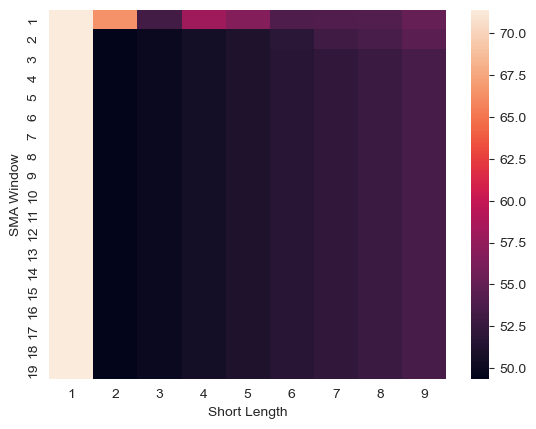

In [203]:
pricing_hm = sns.heatmap(hm)
pricing_hm.set(xlabel='Short Length', ylabel='SMA Window')
plt.show()